## Import Libraries & Load Dataset

In [1]:
import os
import time
import glob
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten, BatchNormalization, Dense, Dropout
from IPython import display
import matplotlib.pyplot as plt
import imageio

## Celeb_A Dataset

In [2]:
images = []
for image in glob.glob(os.path.join("../input/gender-recognition-200k-images-celeba/Dataset/Train/Male/*"))[0:50000]:
    image = cv2.imread(image)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,(64,64))
    image = (image - 127.5) / 127.5
    images.append(image)
images = np.array(images).astype("float32")

In [3]:
Train = tf.data.Dataset.from_tensor_slices(images).shuffle(2000).batch(256)

2022-04-06 07:45:08.287745: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-06 07:45:08.385000: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-06 07:45:08.385865: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-06 07:45:08.390903: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [4]:
import gc
del images
gc.collect()

23

# Model
## Generator Model

In [5]:
generator_model = Sequential()
generator_model.add(Dense(8*8*256,activation="relu",input_dim=100))
generator_model.add(BatchNormalization())
generator_model.add(Reshape((8,8,256)))

generator_model.add(Conv2DTranspose(256,(5,5),strides=(2,2),padding="same",activation="relu"))
generator_model.add(BatchNormalization())

generator_model.add(Conv2DTranspose(128,(5,5),strides=(2,2),padding="same",activation="relu"))
generator_model.add(BatchNormalization())

generator_model.add(Conv2DTranspose(64,(5,5),strides=(1,1),padding="same",activation="relu"))
generator_model.add(BatchNormalization())

generator_model.add(Conv2DTranspose(3,(5,5),strides=(2,2),padding="same",activation="tanh"))

In [6]:
generator_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1654784   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 256)       1638656   
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 256)       1024      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 128)       819328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 128)       5

## Discriminator Model

In [7]:
discriminator_model = Sequential()
discriminator_model.add(Conv2D(64,(5,5),strides=(2,2),activation="relu",padding="same",input_shape=(64,64,3)))
discriminator_model.add(Dropout(0.2))

discriminator_model.add(Conv2D(128,(5,5),strides=(2,2),activation="relu",padding="same"))
discriminator_model.add(Dropout(0.2))

discriminator_model.add(Conv2D(256,(5,5),strides=(2,2),activation="relu",padding="same"))
discriminator_model.add(Dropout(0.2))

discriminator_model.add(Flatten())
discriminator_model.add(Dense(1,activation="sigmoid"))

In [8]:
discriminator_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        4864      
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 256)         819456    
_________________________________________________________________
dropout_2 (Dropout)          (None, 8, 8, 256)         0         
_________________________________________________________________
flatten (Flatten)            (None, 16384)            

In [9]:
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.Adam()
discriminator_optimizer = tf.keras.optimizers.Adam()
discriminator_loss = tf.keras.metrics.Mean()
seed = tf.random.normal([16,100])

In [10]:
def train_step(images):
    noise = tf.random.normal([256,100])
    with tf.GradientTape() as gTape_gen, tf.GradientTape() as gTape_disc:
        generated_images = generator_model(noise,training=True)
        real_images = discriminator_model(images,training=True)
        fake_images = discriminator_model(generated_images,training=True)
        
        loss_gen = loss_function(tf.ones_like(fake_images),fake_images)
        loss_real = loss_function(tf.ones_like(real_images),real_images)
        loss_fake = loss_function(tf.zeros_like(fake_images),fake_images)
        loss_disc = loss_real + loss_fake
        discriminator_loss(loss_disc)
        
    gradient_gen = gTape_gen.gradient(loss_gen,generator_model.trainable_variables)
    gradient_disc = gTape_disc.gradient(loss_disc,discriminator_model.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradient_gen,generator_model.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradient_disc,discriminator_model.trainable_variables))

In [11]:
def save_images(generator_model, epoch, seed):
  prediction = generator_model(seed, training=False)
  fig = plt.figure(figsize=(4, 4))
  for i in range(prediction.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow((np.array(prediction[i, :, :, :] * 127.5)+127.5).astype('uint8'), cmap='gray')
      plt.axis('off')

  plt.savefig(f"image{epoch}.png")
  plt.show()

In [14]:
def train():
  for epoch in range(200):
    start = time.time()
    discriminator_loss.reset_states()
    
    for images in Train:
      train_step(images)
    display.clear_output(wait=True)
    save_images(generator_model,epoch + 1,seed)


    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    print ('Loss: {} '.format(discriminator_loss.result()))

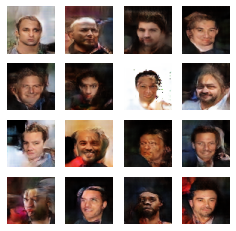

In [15]:
train()

In [16]:
with imageio.get_writer("Celeb.gif", mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)